In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import math
from __future__ import print_function
import cv2 as cv
import argparse

In [6]:
import h5py

h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')

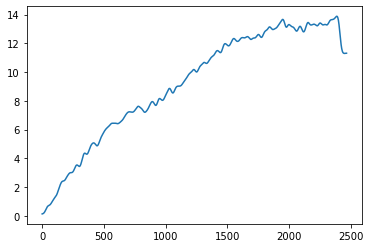

In [4]:
plt.plot(list(f['climbs/0/height_profile']))

In [7]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as ani

h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')
height_profile = f['climbs/0/height_profile']

""" Animator function """
def buildmebarchart(i=int):
    p = plt.plot(height_profile[:(i*10)]) #note it only returns the dataset, up to the point i
    plt.xlabel('Steps')
    plt.ylabel('Height')

    """ MAKE ANIMATED GRAPH """
height_profile = f['climbs/0/height_profile']
fig = plt.figure()
animator = ani.FuncAnimation(fig, buildmebarchart, interval = 10, frames=50)
animator.save('anim_graph.mp4', savefig_kwargs={'transparent': True, 'facecolor': 'none'})
plt.show()

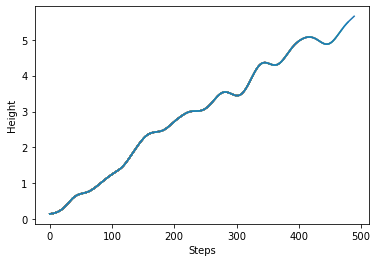

In [8]:
""" MAKE ANIMATED GRAPH """
height_profile = f['climbs/0/height_profile']
fig = plt.figure()
animator = ani.FuncAnimation(fig, buildmebarchart, interval = 10, frames=50)
animator.save('anim_graph.mp4', savefig_kwargs={'transparent': True, 'facecolor': 'none'})
plt.show()

In [31]:
import cv2
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')
f.keys()
list(f['/climbs/all'])[0][1] - list(f['/climbs/all'])[0][0]


240.79999995231628

In [1]:
import cv2
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

# playback speed = out_fps/30 * speed_up   
# speed_up is positive int, e.g. 2 means skip every 2nd frame, 3 skip every 3rd frame
# start_time is the time to start plotting
def overlayGraph(videofile, outfile, graphFunc, start_time, end_time, out_fps, speed_up):
    cap = cv2.VideoCapture(videofile)
    width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer= cv2.VideoWriter(outfile, cv2.VideoWriter_fourcc(*'MP4V'), out_fps, (width,height))    

    """ Set figure size, so it's not bigger than video """
    figure(num=None, figsize=(width/80, height/80), dpi=80)
    i = 0 # count which frame we are on
    while True:
        if not (i % speed_up == 0):
            cap.read()
            i+=1
            continue
        ret,frame = cap.read()

        if not ret:
            break

        # original video has 30fps, so divide frames by 30 to get current time
        time = i / 30;
        
        # we edit frame to overlay a graph. graphFunc could be replaced by
        # another function to modify frames
        if start_time < time and time < end_time:
            frame = graphFunc(time, frame)

        writer.write(frame)
        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == 27:
            break
            
        i+=1

    cap.release()
    writer.release()
    cv2.destroyAllWindows()
    
h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')
height_profile = f['climbs/0/height_profile']
max_height = max(height_profile)
len_height = len(height_profile)
def graphFunc(time, frame):
    if time > len_height:
        return True
    plt.clf()
    # for '/climbs/0/height_profile' we are sampling at 10Hz, i.e. every 0.1s
    ind = min(math.floor(time/0.1), len_height) # stay in bounds
    plt.plot(height_profile[:math.floor(time/0.1)], linewidth=7.0, alpha=0.5)
    plt.ylim(0,max_height)
    plt.xlim(0,len_height)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    
    plt.savefig('plot.png', transparent=True)

    # imread_unchange reads plot.png with 4 channels, i.e. including alpha channel which
    # describes the transparancy
    overlay = cv2.imread('plot.png', cv2.IMREAD_UNCHANGED)
    new_frame = frame

    y_offset = x_offset = 5
    y1, y2 = y_offset, y_offset + overlay.shape[0]
    x1, x2 = x_offset, x_offset + overlay.shape[1]
    alpha_o = overlay[:, :, 3] / 255.0
    alpha_n = 1.0 - alpha_o

    for c in range(0, 3):
        new_frame[y1:y2, x1:x2, c] = (alpha_o * overlay[:, :, c] +
                                  alpha_n * new_frame[y1:y2, x1:x2, c])
    
    return new_frame

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')
height_profile = f['climbs/0/height_profile']
max_height = max(height_profile)
len_height = len(height_profile)
rocket = Image.open('../rocket.png')
rocket = rocket.resize((50,50))

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

def rocketGraphFunc(time, frame):
    if time > len_height:
        return True
    plt.clf()
    # for '/climbs/0/height_profile' we are sampling at 10Hz, i.e. every 0.1s
    ind = min(math.floor(time/0.1), len_height - 1) # stay in bounds
    plt.plot(height_profile[:math.floor(time/0.1)], linewidth=7.0, alpha=0.5)
    
    ax = plt.gca()
    imscatter([math.floor(time/0.1)], [height_profile[math.floor(time/0.1)]],
              '../rocket.png', zoom=0.1, ax=ax)
    plt.ylim(0,max_height)
    plt.xlim(0,len_height)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    
    fig_width = frame.shape[0]
    fig_height = frame.shape[1]
    #plt.figimage(rocket, xo=(math.floor(time/0.1)/len_height) * fig_width,
    #                     yo=(height_profile[math.floor(time/0.1)]/max_height) * fig_height)
    
    plt.savefig('plot.png', transparent=True)

    # imread_unchange reads plot.png with 4 channels, i.e. including alpha channel which
    # describes the transparancy
    overlay = cv2.imread('plot.png', cv2.IMREAD_UNCHANGED)
    new_frame = frame

    y_offset = x_offset = 0
    y1, y2 = y_offset, y_offset + overlay.shape[0]
    x1, x2 = x_offset, x_offset + overlay.shape[1]
    alpha_o = overlay[:, :, 3] / 255.0
    alpha_n = 1.0 - alpha_o

    for c in range(0, 3):
        new_frame[y1:y2, x1:x2, c] = (alpha_o * overlay[:, :, c] +
                                  alpha_n * new_frame[y1:y2, x1:x2, c])

    return new_frame

ValueError: Index (2468) out of range (0-2467)

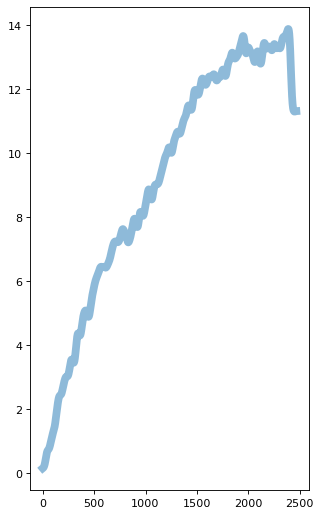

In [7]:
overlayGraph('./data/overhang/Overhang.mp4', 'graphvid.mp4', rocketGraphFunc, 8, 10000, 60, 5)

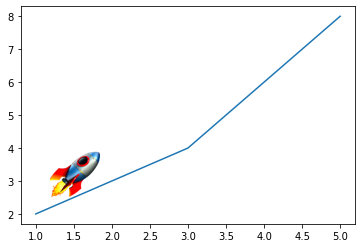

In [77]:
from PIL import Image
import numpy as np
rocket = Image.open('../rocket.png')
rocket = rocket.resize((50,50))


plt.plot([1,2,3,4,5],[2,3,4,6,8])
plt.figimage(rocket, xo=150, yo=50)

plt.clf()

plt.plot([1,2,3,4,5],[2,3,4,6,8])
plt.figimage(rocket, xo=50, yo=50)

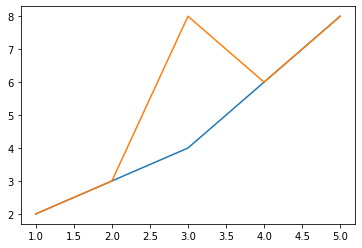

In [67]:
pix = np.array(rocket)
pix.shape
fig, ax = plt.subplots()
ax.plot([1,2,3,4,5],[2,3,4,6,8])
fig.savefig('plot.png')
frame = np.array(Image.open('plot.png'))
overlay = np.array(rocket)

y_offset = x_offset = 60
y1, y2 = y_offset, y_offset + overlay.shape[0]
x1, x2 = x_offset, x_offset + overlay.shape[1]
alpha_o = overlay[:, :, 3] / 255.0
alpha_n = 1.0 - alpha_o
for c in range(0, 3):
    frame[y1:y2, x1:x2, c] = (alpha_o * overlay[:, :, c] +
                              alpha_n * frame[y1:y2, x1:x2, c])
img = Image.fromarray(frame, 'RGBA')


In [50]:
frame.shape

(288, 432, 4)

In [51]:
overlay.shape

(50, 50, 4)